In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
df = pd.read_csv('/Users/jz/Downloads/job_data/2/df_update.csv',index_col=[0])

In [32]:
df = df.drop(columns=['job_title','company','location'])

In [33]:
df.head()

,rating,low_salary_year($),high_salary_year($),reviews,datepost,lat,lon,Is_DA,.Net,ACH,...,UX,Unity,VersionOne,Visio,Visual Basic,Windows,WordPress,Workday,XML,iOS
0,NaN,0,0,NaN,30.0,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,0,0,NaN,30.0,0.000000,0.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.5,0,0,2.0,30.0,40.712728,-74.006015,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,0,0,2.0,30.0,40.712728,-74.006015,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.8,0,0,754.0,30.0,40.789624,-73.959894,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df = df.fillna(0)

In [72]:
skill_list = list(df.columns[8:])

In [35]:
df['low_salary_year($)'] = pd.to_numeric(df['high_salary_year($)'],errors='coerce')

In [36]:
feature_names = list(df.drop(columns=['low_salary_year($)','high_salary_year($)']).columns)

/Users/jz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 17269.53446589834


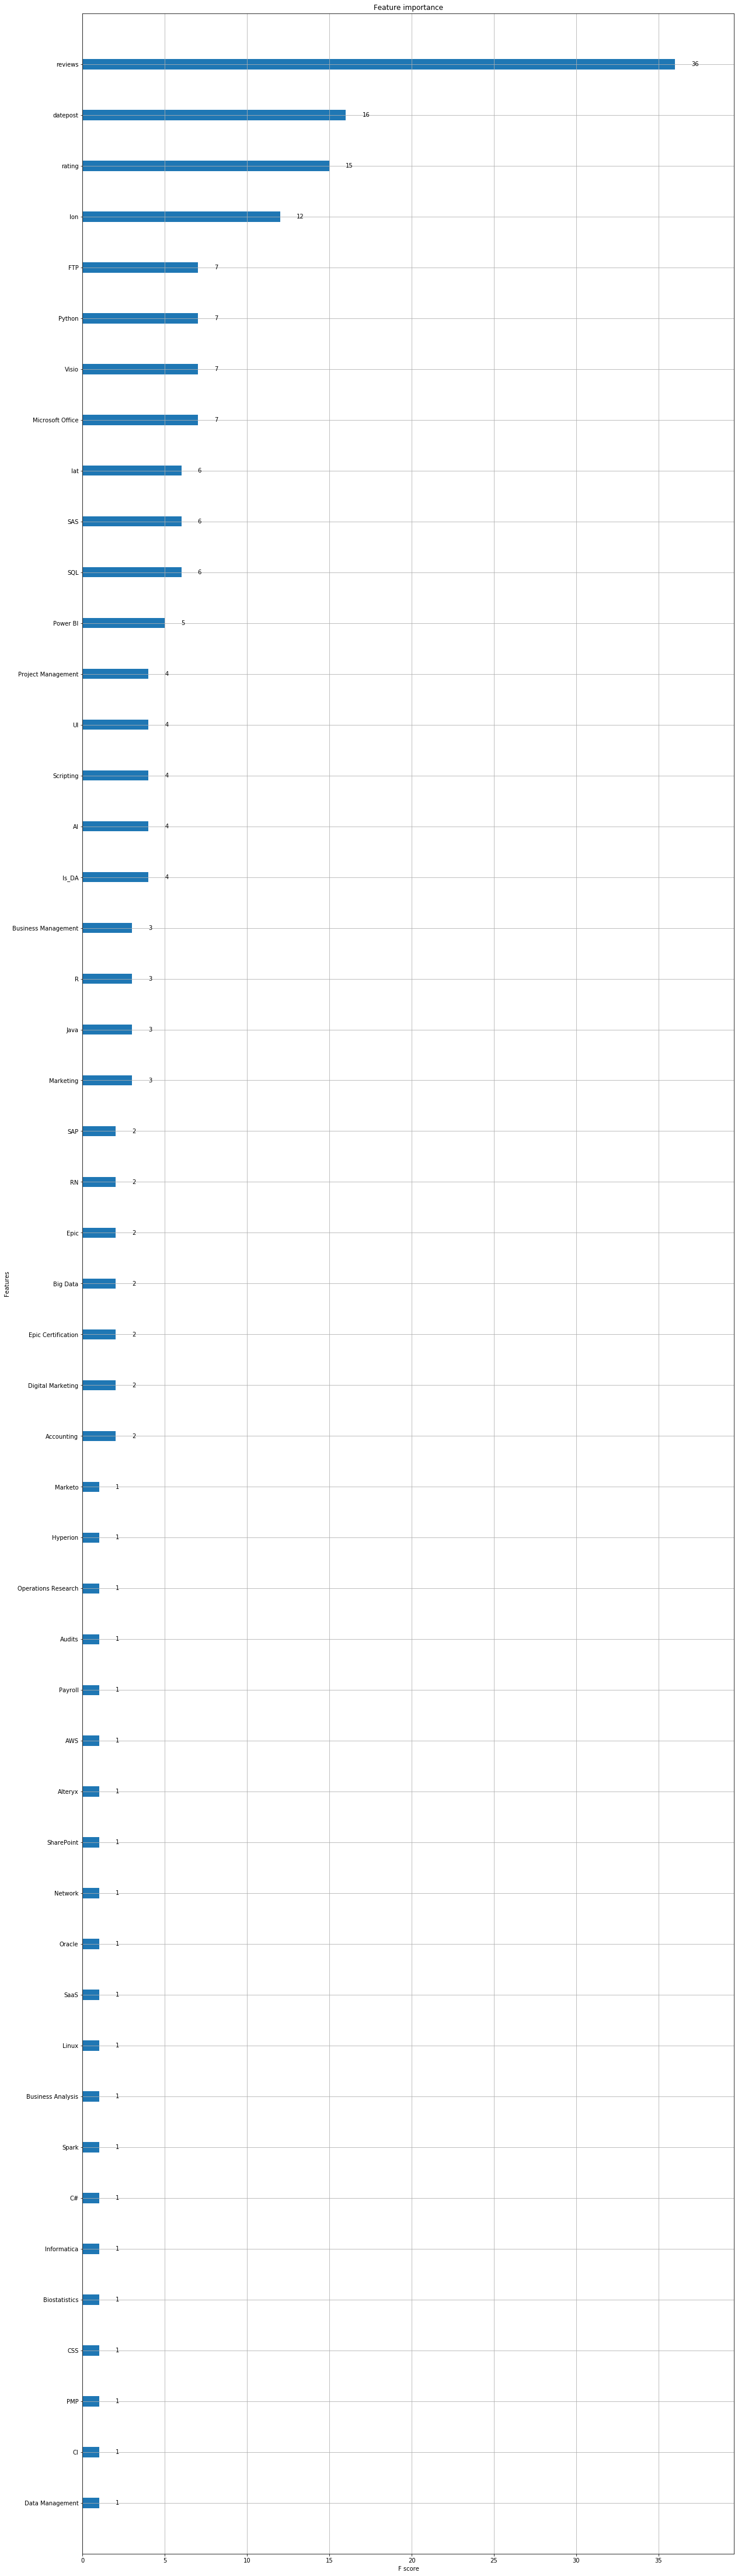

In [37]:
X = df[feature_names]
y = df['low_salary_year($)']

data_dmatrix=xgb.DMatrix(data=X, label=y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

mse=mean_squared_error(y, y_pred)

print('RMSE:',np.sqrt(mse))

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
import matplotlib.pyplot as plt

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20, 80]
plt.show()

/Users/jz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 17269.53446589834


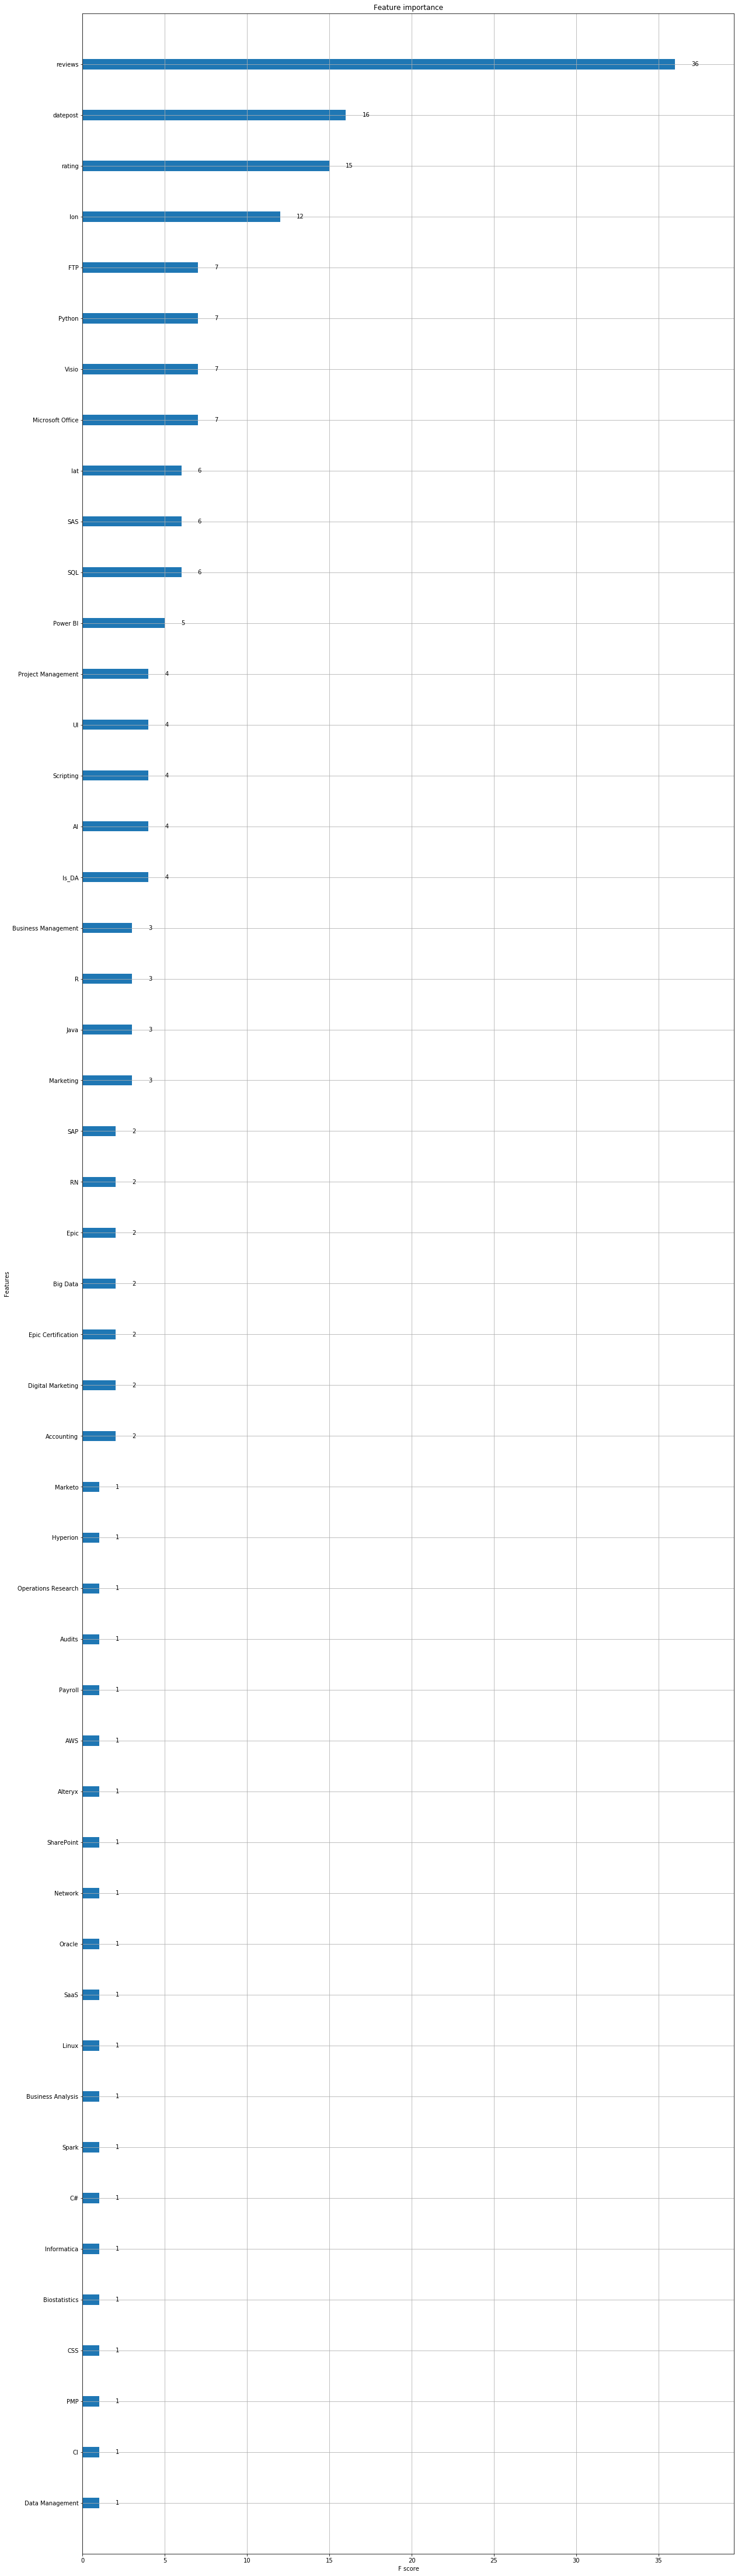

In [38]:
X = df[feature_names]
y = df['high_salary_year($)']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

mse=mean_squared_error(y, y_pred)

print('RMSE:',np.sqrt(mse))

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
import matplotlib.pyplot as plt

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20, 80]
plt.show()

In [39]:
df_feature = pd.DataFrame(xg_reg.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)

In [40]:
df_feature = df_feature.reset_index().drop(columns='index')

In [41]:
feature_sel = []
for row in np.arange(0,len(df_feature)):
    feat = df_feature['feature'][row]
    feature_sel.append(feat)

In [42]:
def accuracy(df,feature_sel):
    filtered_df = df.dropna()
    X = filtered_df[feature_sel]
    Y = filtered_df['rating']
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
    # fit model no training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    return len(feature_sel),accuracy * 100.0

In [43]:
def accuracy_list(y_col,filtered_df,feature_sel):
    
    for i in np.arange(1,len(feature_sel)):
        print (accuracy(filtered_df,feature_sel[:i]))

In [67]:
filtered_df = df.dropna(how='all', subset=feature_sel)

In [68]:
df.shape

(1151, 218)

In [69]:
filtered_df.shape

(1151, 218)

In [23]:
accuracy(df,feature_sel)

ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

In [ ]:
filtered_df = df[df['high_salary_year($)']!=0]

In [ ]:
filtered_df.shape

In [ ]:
filtered_df.head()

In [ ]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

X = filtered_df[feature_sel]
Y = filtered_df['high_salary_year($)']
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
y_pred